In [101]:
import joblib
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from scipy.stats import randint
from sklearn.inspection import permutation_importance

In [3]:
df = fetch_openml(name = 'credit', version= 1)
x = df.data
y = df.target
x.describe().columns
y.describe()
# x.info()
numericke = list(x.describe().columns)
kategorije = list(set(x.columns) - set(numericke))

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numericke),
                                               ('kat', OneHotEncoder(drop='first', handle_unknown='ignore'), kategorije)])

logreg = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(max_iter=4000, C = 7))  
])
svc = Pipeline([
    ('preprocessing', preprocessor),
    ('model', SVC(C=8))  
])
rf = RandomForestClassifier(n_estimators=200)

def namesti(model):
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)    
    print(f"Tačnost modela: {accuracy_score(ytest, pred):.4f}")
    print(confusion_matrix(ytest, pred), ytest.value_counts())
    # print(f"\nModel: {model.named_steps['model'].__class__.__name__}")


In [ ]:
mapiranje_kolona = {
    'RevolvingUtilizationOfUnsecuredLines': 'IskoriscenjeRevolvingKreditaBezOsiguranja',
    'age': 'Starost',
    'NumberOfTime30-59DaysPastDueNotWorse': 'BrojKasnjenja30_59Dana',
    'DebtRatio': 'OdnosDugaPremaPrihodima',
    'MonthlyIncome': 'MesečniPrihod',
    'NumberOfOpenCreditLinesAndLoans': 'BrojOtvorenihKreditnihLinijaIZajmova',
    'NumberOfTimes90DaysLate': 'BrojKasnjenja90Dana',
    'NumberRealEstateLoansOrLines': 'BrojHipotekarnihKreditaILinija',
    'NumberOfTime60-89DaysPastDueNotWorse': 'BrojKasnjenja60_89Dana',
    'NumberOfDependents': 'BrojZavisnihLica'
}

# Promenite imena kolona
x.rename(columns=mapiranje_kolona, inplace=True)
xtrain.rename(columns=mapiranje_kolona, inplace=True)
xtest.rename(columns=mapiranje_kolona, inplace=True)
# Proverite rezultat
print(x.columns)

In [47]:
def namesti(model):
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)    
    acc = accuracy_score(ytest, pred)
    cm = confusion_matrix(ytest, pred)
    
    print(f"\nModel: {model.named_steps['model'].__class__.__name__}")
    print(f"Tačnost modela: {acc:.4f}")
    print("Matrica konfuzije:")
    print(cm)
    print(ytest.value_counts())
    # ROC-AUC samo ako model podržava predict_proba
    if hasattr(model.named_steps['model'], "predict_proba"):
        y_pred_prob = model.predict_proba(xtest)[:, 1]
        roc_auc = roc_auc_score(ytest, y_pred_prob)
        
        # Crtanje ROC krive
        fpr, tpr, _ = roc_curve(ytest, y_pred_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model.named_steps["model"].__class__.__name__}')
        plt.legend(loc="lower right")
        plt.show()

        print(f"ROC-AUC Score: {roc_auc:.4f}")

In [5]:
def crtaj(model):
    trening = np.linspace(150, len(xtrain), 70).astype(int)
    f1train = []
    for i in trening:
        xs = xtrain.iloc[:i]
        ys = ytrain.iloc[:i]
        model.fit(xs,ys)
        pred = model.predict(xs)
        score = f1_score(ys, pred, average='binary')
        f1train.append(score)
    
    f1test = []
    for i in trening:
        xs = xtrain.iloc[:i]
        ys = ytrain.iloc[:i]
        model.fit(xs,ys)
        pred = model.predict(xtest)
        score = f1_score(ytest, pred, average='binary')
        f1test.append(score)
    plt.figure(figsize=(8, 6))
    plt.plot(trening, f1train, marker='o', label='Trening F1-score')
    plt.plot(trening, f1test, marker='o',label='Test F1-score')
    plt.xlabel("Veličina trening skupa")
    plt.ylabel("F1-score")
    plt.title("F1-score u odnosu na veličinu trening skupa")
    plt.xlim(150, 13371)
    plt.ylim(0.6, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

In [6]:
def score(model, x = x, y = y):    
    rez = cross_val_score(model, x, y,scoring="accuracy", cv=5)
    accuracy = {'prosek' : rez.mean(),
                'std' : rez.std()}
    rezroc = cross_val_score(model, x, y,scoring="roc_auc", cv=5)
    roc = {'prosek' : rezroc.mean(),
            'std' : rezroc.std()}
    return accuracy, roc

In [7]:
x.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

joblib.dump(gridLogit.best_estimator_, 'logit.pkl')

In [8]:
logit = joblib.load('logit.pkl')

In [17]:
score(logit)

({'prosek': 0.725439922608636, 'std': 0.008720658265460006},
 {'prosek': 0.7961968966930644, 'std': 0.008210952965245613})


Model: LogisticRegression
Tačnost modela: 0.7278
Matrica konfuzije:
[[1379  292]
 [ 618 1054]]
SeriousDlqin2yrs
1.0    1672
0.0    1671
Name: count, dtype: int64


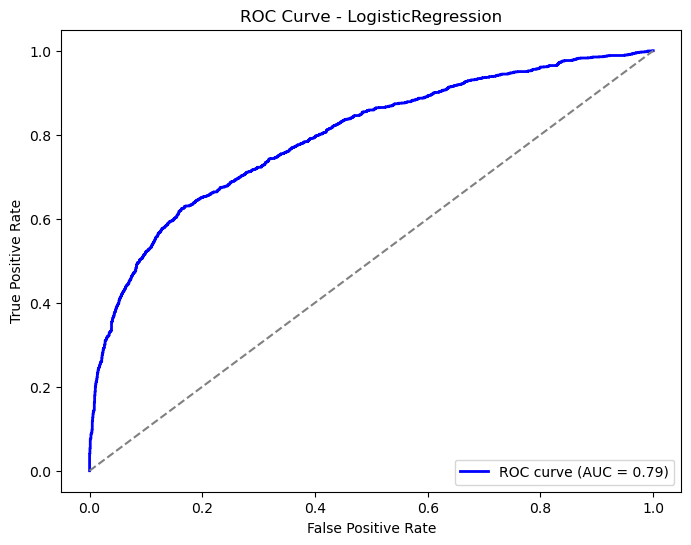

ROC-AUC Score: 0.7942


In [18]:
namesti(logit)

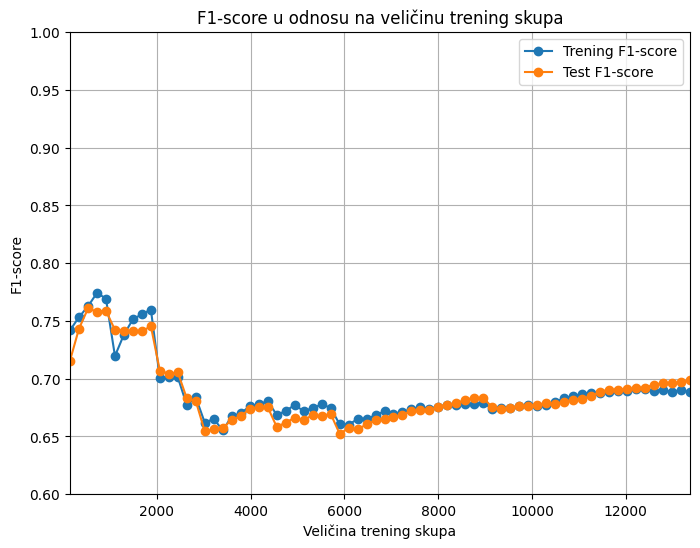

In [41]:
crtaj(logit)

In [9]:
svc = joblib.load('SVC.pkl')

In [78]:
%%time
score(svc)

CPU times: total: 12min 35s
Wall time: 12min 56s


({'prosek': np.float64(0.7469186397150238),
  'std': np.float64(0.002652383711326367)},
 {'prosek': np.float64(0.8151644050226954),
  'std': np.float64(0.005776231159607763)})


Model: SVC
Tačnost modela: 0.7478
Matrica konfuzije:
[[1454  217]
 [ 626 1046]]
SeriousDlqin2yrs
1.0    1672
0.0    1671
Name: count, dtype: int64


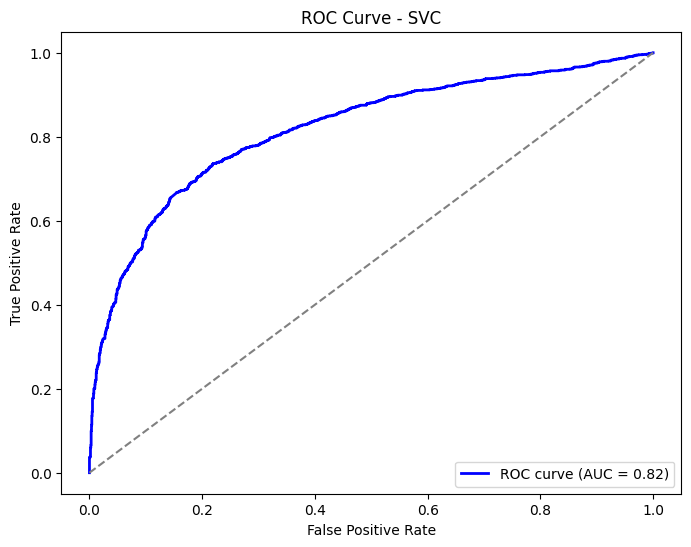

ROC-AUC Score: 0.8190
CPU times: total: 1min 24s
Wall time: 1min 38s


In [79]:
%%time
namesti(svc)

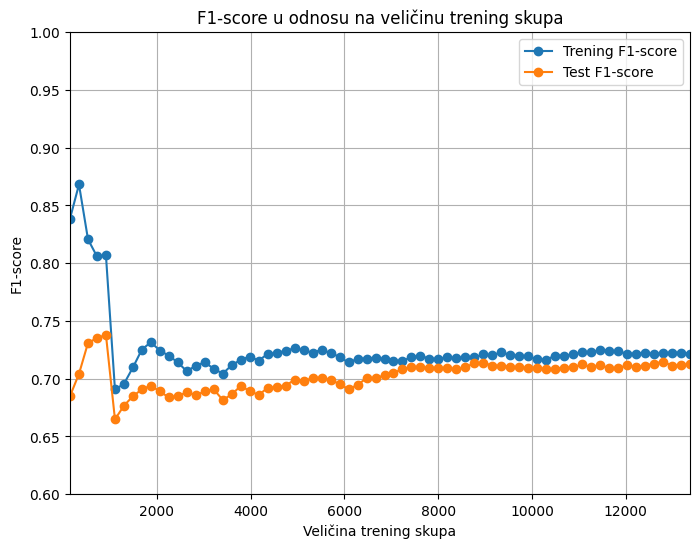

CPU times: total: 20min 29s
Wall time: 21min 41s


In [49]:
%%time
crtaj(svc)

In [10]:
rf = joblib.load('rf.pkl')

Tačnost modela: 0.7792
Matrica konfuzije:
[[1330  341]
 [ 397 1275]]
SeriousDlqin2yrs
1.0    1672
0.0    1671
Name: count, dtype: int64


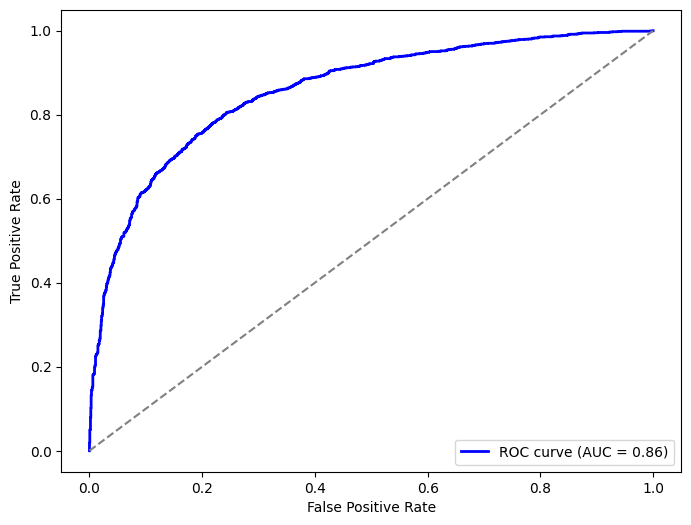

ROC-AUC Score: 0.8574
CPU times: total: 1.66 s
Wall time: 1.81 s


In [12]:
%%time
rf.fit(xtrain, ytrain)
pred = rf.predict(xtest)
acc = accuracy_score(ytest, pred)
cm = confusion_matrix(ytest, pred)
    
print(f"Tačnost modela: {acc:.4f}")
print("Matrica konfuzije:")
print(cm)
print(ytest.value_counts())

y_pred_prob = rf.predict_proba(xtest)[:, 1]
roc_auc = roc_auc_score(ytest, y_pred_prob)

# Crtanje ROC krive
fpr, tpr, _ = roc_curve(ytest, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print(f"ROC-AUC Score: {roc_auc:.4f}")

In [13]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78      1671
         1.0       0.79      0.76      0.78      1672

    accuracy                           0.78      3343
   macro avg       0.78      0.78      0.78      3343
weighted avg       0.78      0.78      0.78      3343



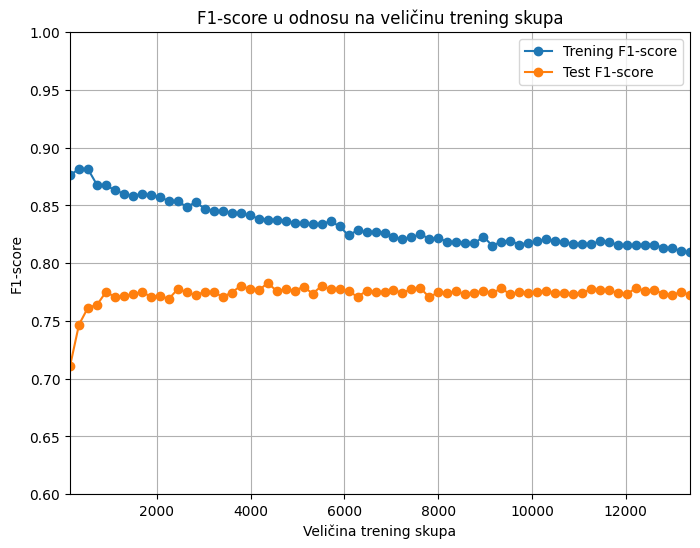

CPU times: total: 1min 50s
Wall time: 1min 54s


In [90]:
%%time
crtaj(rf)

In [29]:
score(rf, x = xtest, y = ytest)

({'prosek': 0.7705687280148225, 'std': 0.012506521472693767},
 {'prosek': 0.8503112231163733, 'std': 0.010807215306428083})

In [57]:
rf

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       n_estimators=50)

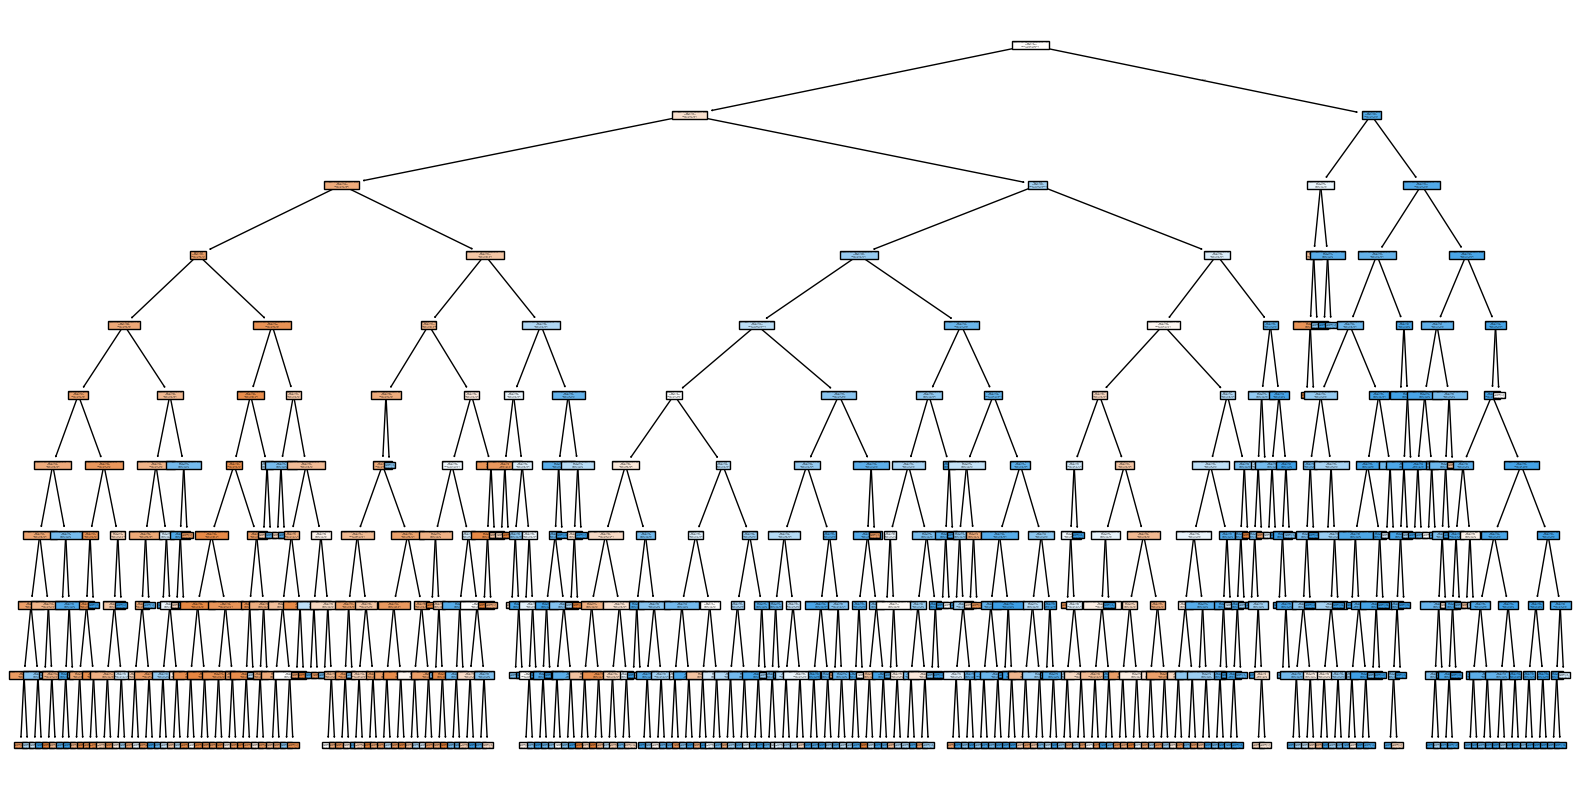

In [55]:
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], feature_names=xtrain.columns, class_names=["Class 0", "Class 1"], filled=True)
plt.show()

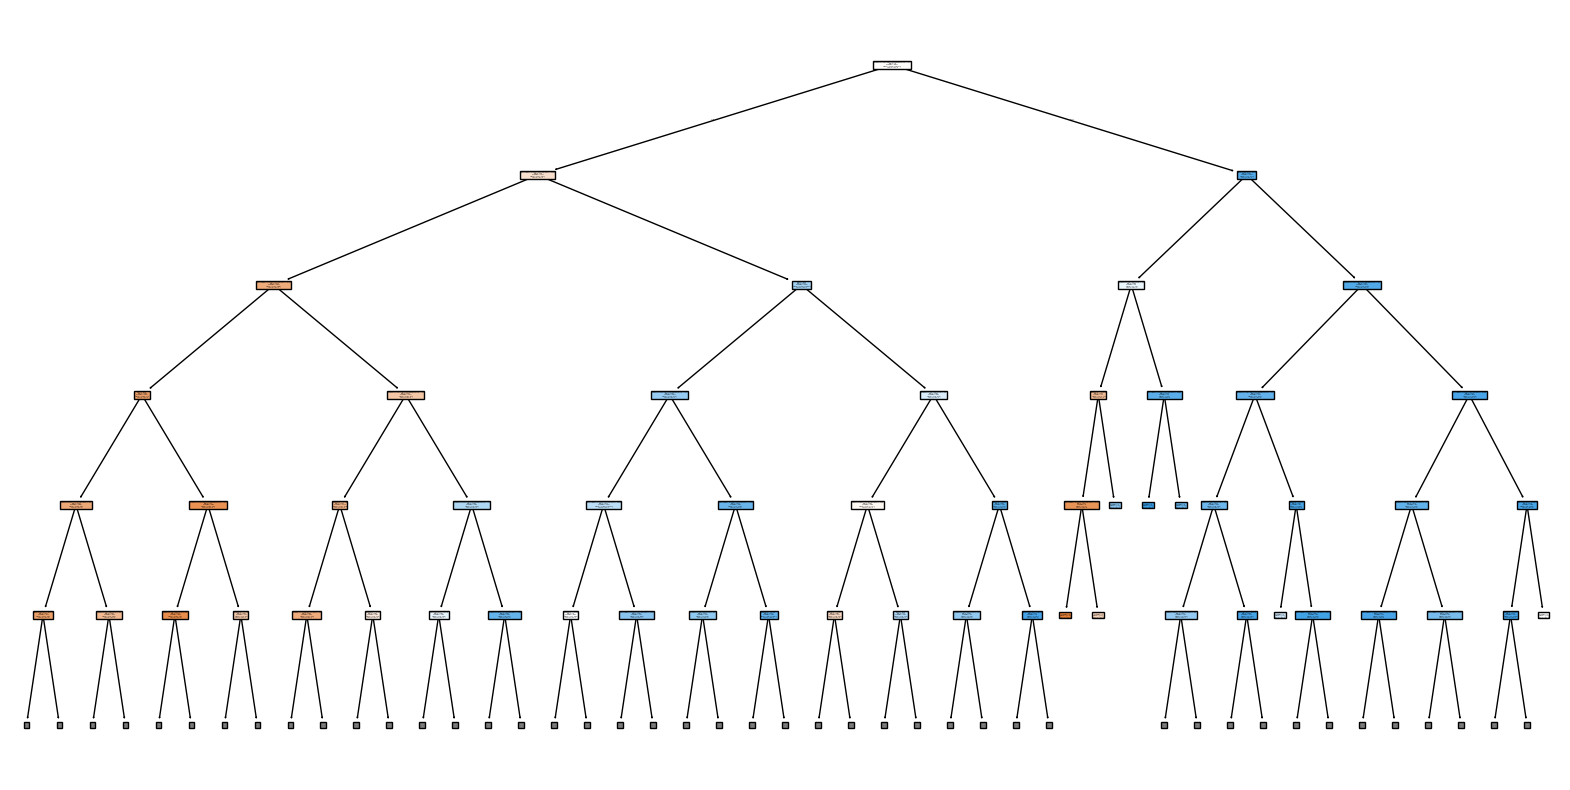

In [119]:
plt.figure(figsize=(20, 10))

# Prikazi samo prvo stablo
plot_tree(rf.estimators_[0], 
          feature_names=xtrain.columns, 
          class_names=["Class 0", "Class 1"], 
          filled=True, 
          max_depth=5)  # Ovdje možeš da smanjiš dubinu

plt.show()

In [ ]:
from sklearn.inspection import partial_dependence

# Generišemo PDP za prvih nekoliko karakteristika
partial_dependence(rf, xtrain, features=[0, 1, 2], feature_names=xtrain.columns, grid_resolution=50)
plt.show()

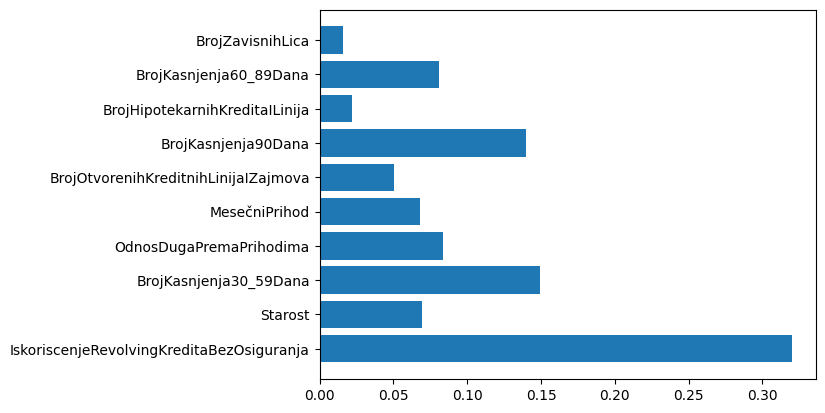

In [80]:
importances = rf.feature_importances_
plt.barh(xtrain.columns, importances)
plt.show()

In [81]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(xtrain)

shap.summary_plot(shap_values[:, :, 1], xtrain)

NameError: name 'shap' is not defined

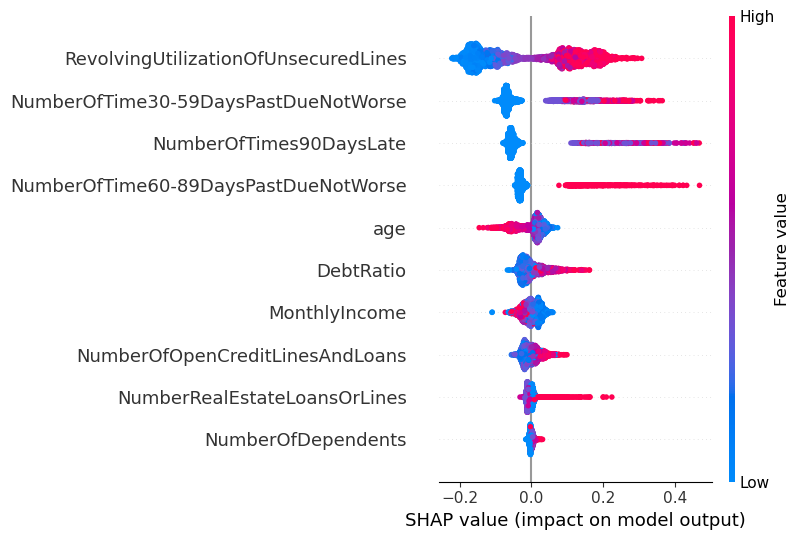

In [110]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(xtest)

shap.summary_plot(shap_values[:, :, 1], xtest)

In [19]:
%%time
rf = RandomForestClassifier(random_state=42)

# Definicija hiperparametara za uzorkovanje
param_dist = {
    'n_estimators': randint(50, 500),  # Nasumično uzorkuje između 50 i 500
    'max_depth': [10, 20, 30, None],    # Može uključivati i None (bez ograničenja)
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': randint(2, 20),  # Nasumično uzorkuje između 2 i 20
    'min_samples_leaf': randint(1, 10),   # Nasumično uzorkuje između 1 i 10
    'bootstrap': [True, False]           # Isprobaj i sa/sampled replacement
}

# Inicijalizacija RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Pokreni pretragu (koristi X_train i y_train)
random_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 10.6 s
Wall time: 37min


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF0EF4050>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF0EA0050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEE7889BF0>},
                   random_state=42, scoring='roc_auc', verbose=3)

In [26]:
random_search.best_estimator_.score(xtrain,ytrain)

0.8059980554932317

In [27]:
score(random_search.best_estimator_)

({'prosek': np.float64(0.7768933826194877),
  'std': np.float64(0.005175661556936104)},
 {'prosek': np.float64(0.8551798116338338),
  'std': np.float64(0.005027417403925373)})

In [29]:
rf = random_search.best_estimator_

In [34]:
rf

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BF5230>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BFC4B0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BFC730>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BF4F70>},
                   random_state=42, scoring='roc_auc', verbose=3)

In [33]:
%%time
param_dist_narrow = {
    'n_estimators': randint(200, 400),         # Najbolji rezultati između 200-400
    'max_depth': randint(10, 30),              # Dubina 10-30 (izbjegavati None)
    'max_features': ['sqrt', 'log2'],          # Ne koristiti None (overfitting)
    'min_samples_leaf': randint(1, 10),        # Manji raspon nego ranije
    'min_samples_split': randint(2, 20),       # Optimizovano prema najboljim kombinacijama
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_narrow,
    n_iter=10, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Pokreni na train podacima
rf.fit(xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 8.27 s
Wall time: 5min 28s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BF5230>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BFC4B0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BFC730>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AEF3BF4F70>},
                   random_state=42, scoring='roc_auc', verbose=3)

In [37]:
rf.best_estimator_

RandomForestClassifier(max_depth=27, max_features='log2', min_samples_leaf=9,
                       min_samples_split=15, n_estimators=208, random_state=42)

In [42]:
rf.best_estimator_.score(xtrain,ytrain)

0.8383815720589335

In [43]:
joblib.dump(rf.best_estimator_, 'rf.pkl')

['rf.pkl']

In [44]:
rf = joblib.load('rf.pkl')

Tačnost modela: 0.7759
Matrica konfuzije:
[[1315  356]
 [ 393 1279]]
SeriousDlqin2yrs
1.0    1672
0.0    1671
Name: count, dtype: int64


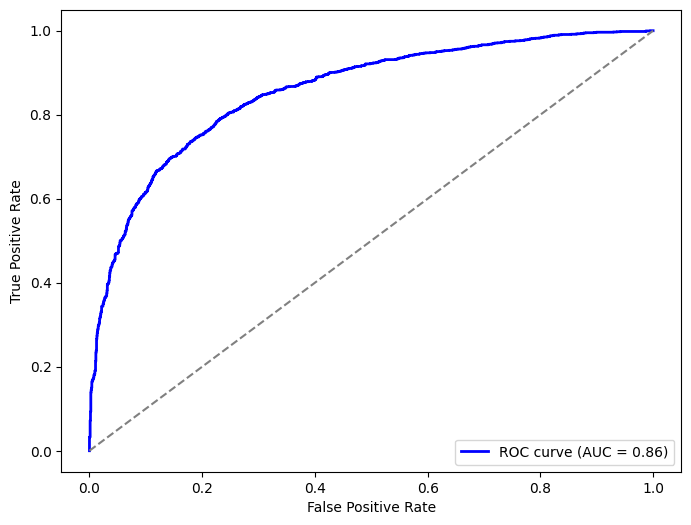

ROC-AUC Score: 0.8564
CPU times: total: 7.66 s
Wall time: 9.36 s


In [49]:
%%time
rf.fit(xtrain, ytrain)
pred = rf.predict(xtest)
acc = accuracy_score(ytest, pred)
cm = confusion_matrix(ytest, pred)
    
print(f"Tačnost modela: {acc:.4f}")
print("Matrica konfuzije:")
print(cm)
print(ytest.value_counts())

y_pred_prob = rf.predict_proba(xtest)[:, 1]
roc_auc = roc_auc_score(ytest, y_pred_prob)

# Crtanje ROC krive
fpr, tpr, _ = roc_curve(ytest, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print(f"ROC-AUC Score: {roc_auc:.4f}")

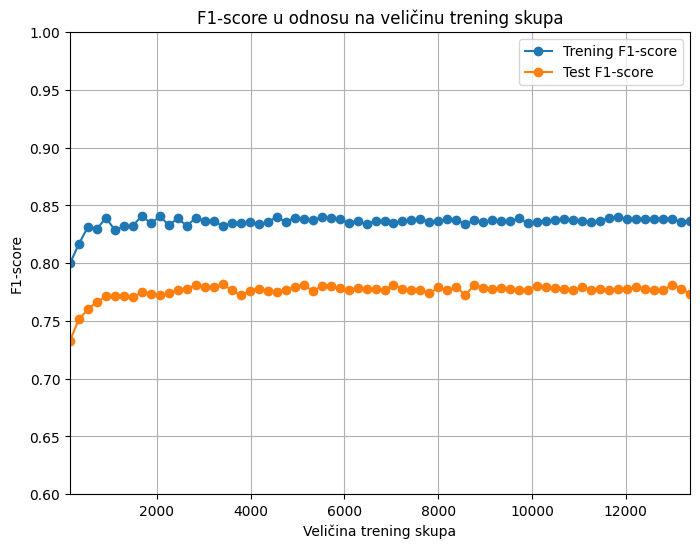

CPU times: total: 8min 47s
Wall time: 9min 30s


In [105]:
%%time
crtaj(rf)

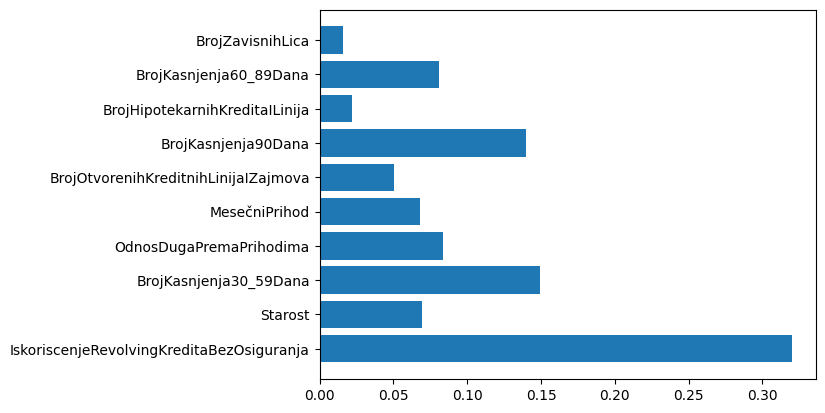

In [88]:
importances = rf.feature_importances_
plt.barh(xtrain.columns, importances)
plt.show()

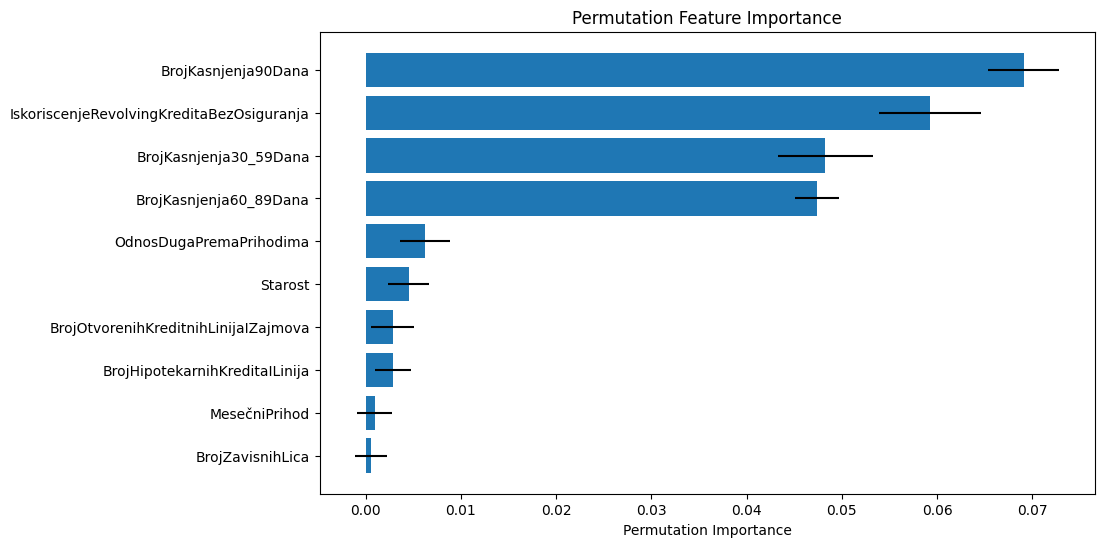

In [99]:
result = permutation_importance(rf, xtest, ytest, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    'feature': xtrain.columns,
    'importance_mean':result.importances_mean,
    'importance_std':result.importances_std
}).sort_values('importance_mean', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(perm_importance['feature'], perm_importance['importance_mean'], xerr=perm_importance['importance_std'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

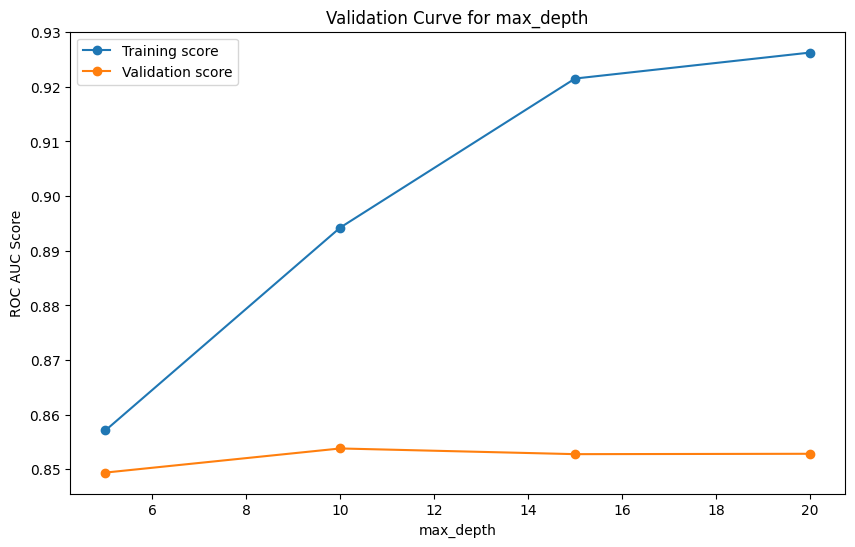

In [103]:
param_range = [5, 10, 15, 20, None]
train_scores, test_scores = validation_curve(
    rf, xtrain, ytrain, param_name='max_depth', param_range=param_range, 
    cv=5, scoring='roc_auc', n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(param_range, train_scores_mean, 'o-', label='Training score')
plt.plot(param_range, test_scores_mean, 'o-', label='Validation score')
plt.xlabel('max_depth')
plt.ylabel('ROC AUC Score')
plt.title('Validation Curve for max_depth')
plt.legend(loc='best')
plt.show()

In [70]:
errors = xtest[ytest != pred]
errors['true_label'] = ytest[ytest != pred]
errors['predicted_label'] = pred[ytest != pred]

C:\Users\bogdan.sliskovic\AppData\Local\Temp\ipykernel_7104\3076249920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['true_label'] = ytest[ytest != pred]
C:\Users\bogdan.sliskovic\AppData\Local\Temp\ipykernel_7104\3076249920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['predicted_label'] = pred[ytest != pred]


In [71]:
errors['true_label']

3485     0.0
16663    1.0
12746    1.0
13824    1.0
16062    1.0
        ... 
9494     1.0
14483    1.0
3833     0.0
16310    1.0
6510     0.0
Name: true_label, Length: 749, dtype: float64

In [72]:
errors['predicted_label'] 

3485     1.0
16663    0.0
12746    0.0
13824    0.0
16062    0.0
        ... 
9494     0.0
14483    0.0
3833     1.0
16310    0.0
6510     1.0
Name: predicted_label, Length: 749, dtype: float64

In [73]:
errors

,IskoriscenjeRevolvingKreditaBezOsiguranja,Starost,BrojKasnjenja30_59Dana,OdnosDugaPremaPrihodima,MesečniPrihod,BrojOtvorenihKreditnihLinijaIZajmova,BrojKasnjenja90Dana,BrojHipotekarnihKreditaILinija,BrojKasnjenja60_89Dana,BrojZavisnihLica,true_label,predicted_label
3485,0.223510,40.0,1.0,0.443281,9167.0,16.0,0.0,1.0,0.0,2.0,0.0,1.0
16663,0.018149,62.0,0.0,0.191742,8500.0,19.0,0.0,2.0,0.0,1.0,1.0,0.0
12746,0.612599,51.0,0.0,0.521019,7183.0,14.0,0.0,3.0,0.0,2.0,1.0,0.0
13824,0.213947,63.0,1.0,0.368644,9930.0,14.0,0.0,4.0,0.0,0.0,1.0,0.0
16062,0.245455,56.0,0.0,0.725299,1841.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9494,1.000000,29.0,0.0,0.516572,3861.0,4.0,0.0,2.0,0.0,1.0,1.0,0.0
14483,0.430421,55.0,0.0,0.668178,8600.0,12.0,0.0,3.0,0.0,1.0,1.0,0.0
3833,0.590137,62.0,0.0,0.695146,5500.0,16.0,0.0,1.0,0.0,0.0,0.0,1.0
16310,0.300506,39.0,0.0,0.371560,6539.0,13.0,0.0,2.0,0.0,6.0,1.0,0.0


In [106]:
errors[errors['predicted_label'] == 1]

,IskoriscenjeRevolvingKreditaBezOsiguranja,Starost,BrojKasnjenja30_59Dana,OdnosDugaPremaPrihodima,MesečniPrihod,BrojOtvorenihKreditnihLinijaIZajmova,BrojKasnjenja90Dana,BrojHipotekarnihKreditaILinija,BrojKasnjenja60_89Dana,BrojZavisnihLica,true_label,predicted_label
3485,0.223510,40.0,1.0,0.443281,9167.0,16.0,0.0,1.0,0.0,2.0,0.0,1.0
1358,0.960452,24.0,1.0,0.109556,2500.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0
5025,0.805659,40.0,2.0,0.573506,4400.0,9.0,0.0,0.0,0.0,2.0,0.0,1.0
4488,0.237463,52.0,1.0,0.290237,7200.0,7.0,0.0,2.0,0.0,1.0,0.0,1.0
828,0.168522,42.0,0.0,0.734480,4300.0,16.0,0.0,2.0,0.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2531,0.616779,53.0,0.0,0.997059,8500.0,25.0,0.0,2.0,0.0,3.0,0.0,1.0
1945,1.000000,40.0,1.0,0.077490,8000.0,8.0,0.0,0.0,0.0,2.0,0.0,1.0
4338,0.424858,26.0,2.0,0.533697,2017.0,5.0,0.0,0.0,1.0,0.0,0.0,1.0
3833,0.590137,62.0,0.0,0.695146,5500.0,16.0,0.0,1.0,0.0,0.0,0.0,1.0


In [77]:
errors['true_label'].value_counts()

true_label
1.0    393
0.0    356
Name: count, dtype: int64

In [98]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(max_depth=27, max_features='log2', min_samples_leaf=9,
                       min_samples_split=15, n_estimators=208, random_state=42)